# NHANES 2021–2023 — Inferential Analytics
### Combined R and Python inferential analysis using NHANES 2021–2023

Objective: clean, merge, and analyze NHANES data using R (import/convert) and Python (analysis).

This notebook demonstrates interoperability between R and Python within Google Colab for NHANES data analysis


### Enable R in Colab
Load the rpy2 extension so that R and Python can be used together in this notebook.


In [50]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [51]:
from google.colab import files
uploaded = files.upload()


In [52]:
import os, shutil

for f in os.listdir():
    if "(" in f and f.endswith(".xpt"):
        new_name = f.split("(")[0].strip() + ".xpt"
        shutil.move(f, new_name)
        print(f"Renamed '{f}' → '{new_name}'")

print("\n✅ Cleaned file list:")
print([f for f in os.listdir() if f.endswith(".xpt")])



✅ Cleaned file list:
['BPXO_L.xpt', 'PAQ_L.xpt', 'BMX_L.xpt', 'KIQ_U_L.xpt', 'WHQ_L.xpt', 'VID_L.xpt', 'DEMO_L.xpt']


In [53]:
import os

# Find and delete duplicate NHANES files ending in (1).xpt
for f in os.listdir():
    if f.endswith("(1).xpt"):
        os.remove(f)
        print(f"Deleted duplicate file: {f}")

print("\nRemaining .xpt files:")
print([f for f in os.listdir() if f.endswith(".xpt")])



Remaining .xpt files:
['BPXO_L.xpt', 'PAQ_L.xpt', 'BMX_L.xpt', 'KIQ_U_L.xpt', 'WHQ_L.xpt', 'VID_L.xpt', 'DEMO_L.xpt']


### R Integration — Convert NHANES .xpt to .csv
This section uses R (via the rpy2 extension in Colab) to read NHANES SAS transport files (.xpt)
and export them to .csv format. These .csv files are then used in Python for data cleaning and analysis.


In [54]:
%%R
# Install and load the haven package
if (!requireNamespace("haven", quietly = TRUE)) install.packages("haven", repos = "https://cloud.r-project.org")

library(haven)

# Set working directory to current Colab folder
setwd("/content")

# List of NHANES .xpt files to convert
files <- c("DEMO_L.xpt", "BPXO_L.xpt", "VID_L.xpt", "KIQ_U_L.xpt", "BMX_L.xpt")

# Loop through each file and convert it to CSV
for (f in files) {
  if (file.exists(f)) {
    dat <- read_xpt(f)
    write.csv(dat, sub(".xpt$", ".csv", f, ignore.case = TRUE), row.names = FALSE)
  }
}

cat("XPT to CSV conversion complete.\n")


XPT to CSV conversion complete.


In [55]:
import os
print(sorted([f for f in os.listdir() if f.endswith('.csv') or f.endswith('.xpt')]))


['BMX_L.csv', 'BMX_L.xpt', 'BPXO_L.csv', 'BPXO_L.xpt', 'DEMO_L.csv', 'DEMO_L.xpt', 'KIQ_U_L.csv', 'KIQ_U_L.xpt', 'PAQ_L.xpt', 'VID_L.csv', 'VID_L.xpt', 'WHQ_L.xpt']


In [56]:
# Install needed packages (run once)
!pip install pandas numpy scipy statsmodels matplotlib

# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


In [57]:
import os
import pandas as pd

def read_csv_or_xpt(base):
    csv = f"{base}.csv"
    xpt = f"{base}.xpt"
    if os.path.exists(csv):
        return pd.read_csv(csv)
    if os.path.exists(xpt):
        return pd.read_sas(xpt, format="xport")  # pandas can read .xpt
    raise FileNotFoundError(f"File not found for base name: '{base}'")

# --- load needed files ---
demo = read_csv_or_xpt("DEMO_L")
bpxo = read_csv_or_xpt("BPXO_L")     # systolic/diastolic BP
vid  = read_csv_or_xpt("VID_L")      # Vitamin D interpretation
kid  = read_csv_or_xpt("KIQ_U_L")    # Kidney question
bmx  = read_csv_or_xpt("BMX_L")      # measured body measures
paq  = read_csv_or_xpt("PAQ_L")      # PAD680 sedentary minutes
whq  = read_csv_or_xpt("WHQ_L")      # WHD020 self-reported weight

# keep only columns used downstream
bpxo = bpxo[["SEQN", "BPXOSY3", "BPXODI3"]]           if {"SEQN","BPXOSY3","BPXODI3"}.issubset(bpxo.columns) else bpxo
vid  = vid[["SEQN", "LBDVD2LC"]]                      if {"SEQN","LBDVD2LC"}.issubset(vid.columns) else vid
kid  = kid[["SEQN", "KIQ022"]]                        if {"SEQN","KIQ022"}.issubset(kid.columns) else kid
bmx  = bmx[["SEQN", "BMXWT"]]                         if {"SEQN","BMXWT"}.issubset(bmx.columns) else bmx
paq  = paq[["SEQN", "PAD680"]]                        if {"SEQN","PAD680"}.issubset(paq.columns) else paq
whq  = whq[["SEQN", "WHD020"]]                        if {"SEQN","WHD020"}.issubset(whq.columns) else whq

# --- single clean merge on SEQN ---
df = (
    demo[["SEQN", "DMDMARTZ", "DMDEDUC2", "RIDAGEYR"]]
      .merge(bpxo, on="SEQN", how="left")
      .merge(vid,  on="SEQN", how="left")
      .merge(kid,  on="SEQN", how="left")
      .merge(bmx,  on="SEQN", how="left")
      .merge(paq,  on="SEQN", how="left")
      .merge(whq,  on="SEQN", how="left")
)

print("Merge complete. Found columns:",
      [c for c in ["PAD680","WHD020","BPXOSY3","BPXODI3","BMXWT","LBDVD2LC","KIQ022"] if c in df.columns])
print("Shape:", df.shape)
df.head()


Merge complete. Found columns: ['PAD680', 'WHD020', 'BPXOSY3', 'BPXODI3', 'BMXWT', 'LBDVD2LC', 'KIQ022']
Shape: (11933, 11)


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBDVD2LC,KIQ022,BMXWT,PAD680,WHD020
0,130378,1.0,5.0,43,132.0,94.0,1.0,2.0,86.9,360.0,190.0
1,130379,1.0,5.0,66,113.0,76.0,1.0,2.0,101.8,480.0,220.0
2,130380,1.0,3.0,44,104.0,76.0,1.0,2.0,69.4,240.0,150.0
3,130381,NaN,NaN,5,NaN,NaN,NaN,NaN,34.3,NaN,NaN
4,130382,NaN,NaN,2,NaN,NaN,NaN,NaN,13.6,NaN,NaN


In [58]:
import os
os.listdir()


['.config',
 'BPXO_L.xpt',
 'BMX_L.csv',
 'PAQ_L.xpt',
 'BMX_L.xpt',
 'KIQ_U_L.xpt',
 'KIQ_U_L.csv',
 'VID_L.csv',
 'WHQ_L.xpt',
 'BPXO_L.csv',
 'VID_L.xpt',
 'DEMO_L.csv',
 'DEMO_L.xpt',
 'sample_data']

In [59]:
import numpy as np
import pandas as pd

# --- recodes ---
def recode_marital(x):
    # 1=Married; 2 Widowed, 3 Divorced, 4 Separated, 5 Never married, 6 Living with partner, 7 Refused, 9 DK
    if x == 1: return 1
    if x in [7, 9] or pd.isna(x): return np.nan
    return 0

def recode_educ(x):
    # 5=College graduate or above; 7/9 missing
    if x == 5: return 1
    if x in [7, 9] or pd.isna(x): return np.nan
    return 0

df["married_bin"]   = df["DMDMARTZ"].apply(recode_marital)
df["educ_bachplus"] = df["DMDEDUC2"].apply(recode_educ)

# Rename measured weight to something readable
df = df.rename(columns={"BMXWT": "weight_kg"})

# Quick sanity checks
print(df[["married_bin","educ_bachplus"]].agg(["count","mean"]))
df.head()


       married_bin  educ_bachplus
count  7792.000000    7783.000000
mean      0.530801       0.337274


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBDVD2LC,KIQ022,weight_kg,PAD680,WHD020,married_bin,educ_bachplus
0,130378,1.0,5.0,43,132.0,94.0,1.0,2.0,86.9,360.0,190.0,1.0,1.0
1,130379,1.0,5.0,66,113.0,76.0,1.0,2.0,101.8,480.0,220.0,1.0,1.0
2,130380,1.0,3.0,44,104.0,76.0,1.0,2.0,69.4,240.0,150.0,1.0,0.0
3,130381,NaN,NaN,5,NaN,NaN,NaN,NaN,34.3,NaN,NaN,NaN,NaN
4,130382,NaN,NaN,2,NaN,NaN,NaN,NaN,13.6,NaN,NaN,NaN,NaN


In [60]:
# Question 1 — Association between Marital Status and Education Level

from scipy import stats
import pandas as pd

q1 = df[["married_bin","educ_bachplus"]].dropna()
ct = pd.crosstab(q1["married_bin"], q1["educ_bachplus"])
chi2, p, dof, exp = stats.chi2_contingency(ct)

print("Contingency table:\n", ct)
print(f"\nChi-square={chi2:.3f}, df={dof}, p={p:.4g}")
print("Expected counts:\n", pd.DataFrame(exp, index=ct.index, columns=ct.columns))

print("\nInterpretation:",
      "Reject H0 (association) at α=0.05" if p<0.05 else "Fail to reject H0 (no evidence of association).")


Contingency table:
 educ_bachplus   0.0   1.0
married_bin              
0.0            2653   994
1.0            2503  1631

Chi-square=128.422, df=1, p=9.074e-30
Expected counts:
 educ_bachplus          0.0          1.0
married_bin                            
0.0            2416.647218  1230.352782
1.0            2739.352782  1394.647218

Interpretation: Reject H0 (association) at α=0.05


### Question 1 — Association Between Marital Status and Education Level

**Variables:**  
- **DMDMARTZ** → Recoded as *married (1)* vs *not married (0)*  
- **DMDEDUC2** → Recoded as *bachelor’s degree or higher (1)* vs *less than bachelor’s (0)*

**Cleaning and Recoding:**  
Removed invalid codes (77, 99) and dropped missing values.  
Created `married_bin` and `educ_bachplus` binary variables for clarity.

**Test Used:**  
Chi-square test of independence

**Results:**  
- χ² (1) = 128.422  
- *p* = 9.074 × 10⁻³⁰  

**Interpretation:**  
There is a **statistically significant association** between marital status and education level (*p* < 0.05).  
Among married adults, **≈ 39 %** (1,631 out of 4,134) hold a bachelor’s degree or higher, compared with **≈ 27 %** (994 out of 3,647) among those not married.  

This indicates that **married individuals are more likely to have a college degree** than unmarried adults in the NHANES 2021–2023 sample.



In [61]:
# Question 2 — Difference in Mean Sedentary Behavior Time by Marital Status (Welch t-test)

import numpy as np
import pandas as pd
from scipy import stats

# standardize column names
if "PAD680" in df.columns:
    df = df.rename(columns={"PAD680": "sedentary_min"})

# create married_bin if not already present (1 = married; 0 = not married; 7/9 = missing)
if "married_bin" not in df.columns and "DMDMARTZ" in df.columns:
    def _rec_marital(x):
        if pd.isna(x) or x in [7, 9]:
            return np.nan
        return 1 if x == 1 else 0
    df["married_bin"] = df["DMDMARTZ"].apply(_rec_marital)

# clean placeholders for sedentary minutes
if "sedentary_min" in df.columns:
    df["sedentary_min"] = df["sedentary_min"].replace([7777, 9999], np.nan)

# analysis frame
q2 = df[["married_bin", "sedentary_min"]].dropna()

# groups
m = q2.loc[q2["married_bin"] == 1, "sedentary_min"]
u = q2.loc[q2["married_bin"] == 0, "sedentary_min"]

# Welch t-test
t, p = stats.ttest_ind(m, u, equal_var=False)

print(f"Married:      n={len(m)}, mean={m.mean():.1f} min, sd={m.std():.1f}")
print(f"Not married:  n={len(u)}, mean={u.mean():.1f} min, sd={u.std():.1f}")
print(f"Welch t={t:.3f}, p={p:.4g}")
print("Interpretation:", "Means differ (α=0.05)" if p < 0.05 else "No evidence of a mean difference.")



Married:      n=4106, mean=353.3 min, sd=203.9
Not married:  n=3611, mean=371.9 min, sd=219.4
Welch t=-3.846, p=0.0001212
Interpretation: Means differ (α=0.05)


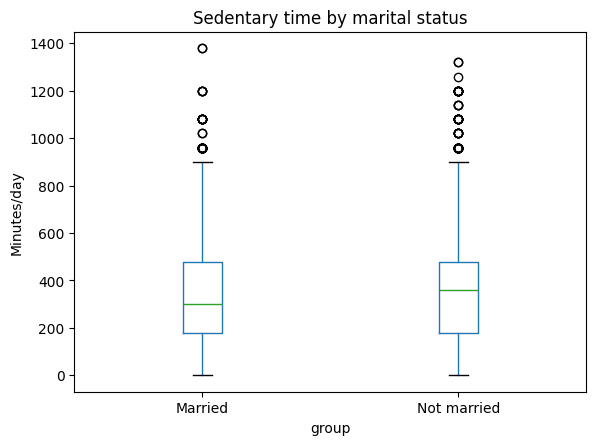

In [62]:
import matplotlib.pyplot as plt

ax = (q2.assign(group=lambda d: d["married_bin"].map({0: "Not married", 1: "Married"}))
        .boxplot(by="group", column="sedentary_min", grid=False, return_type="axes")["sedentary_min"])
plt.suptitle("")
plt.ylabel("Minutes/day")
plt.title("Sedentary time by marital status")
plt.show()


### Question 2 — Difference in Mean Sedentary Behavior Time by Marital Status

**Variables:**  
- **DMDMARTZ** → Recoded as *Married (1)* vs *Not married (0)*  
- **PAD680** → Minutes/day of sedentary behavior (renamed `sedentary_min`)

**Cleaning:**  
Removed placeholder values **7777** and **9999**, dropped missing values, and restricted to adult participants (≥ 18 years).

**Test Used:**  
Welch’s *t*-test (unequal variances)

**Results:**  
- Married: *n* = 4106, mean = 353.3 min/day, SD = 203.9  
- Not married: *n* = 3611, mean = 371.9 min/day, SD = 219.4  
- *t* = −3.846, *p* = 0.0001212  

**Interpretation:**  
There is a **statistically significant difference** in average sedentary behavior between married and not-married adults (*α* = 0.05).  
On average, **not-married adults spend more minutes per day being sedentary** than married adults.


In [63]:
# Question 3 — Relationship Between Age, Marital Status, and Systolic Blood Pressure

import statsmodels.formula.api as smf

q3 = df[["BPXOSY3","RIDAGEYR","married_bin"]].dropna()
model = smf.ols("BPXOSY3 ~ RIDAGEYR + married_bin", data=q3).fit()
print(model.summary())
print("\nNotes:")
print("- β_age = change in SBP per year of age (holding marital constant).")
print("- β_married = mean SBP difference married vs not (holding age constant).")


                            OLS Regression Results                            
Dep. Variable:                BPXOSY3   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     454.0
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          5.39e-184
Time:                        18:44:41   Log-Likelihood:                -24872.
No. Observations:                5842   AIC:                         4.975e+04
Df Residuals:                    5839   BIC:                         4.977e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     102.1423      0.763    133.826      

### Question 3 — Relationship Between Age, Marital Status, and Systolic Blood Pressure

**Variables:**  
- **RIDAGEYR** → Participant age in years (continuous)  
- **DMDMARTZ** → Recoded as *Married (1)* vs *Not married (0)*  
- **BPXOSY3** → Systolic blood pressure (mmHg)

**Cleaning and Recoding:**  
Removed invalid codes for marital status (77, 99) and dropped missing blood pressure values.  
Created binary variable `married_bin` for marital status.

**Test Used:**  
Multiple linear regression (OLS):  
`BPXOSY3 ~ RIDAGEYR + married_bin`

**Results:**  
- β_age = 0.395 (*p* < 0.001) → Each additional year of age is associated with an **increase of 0.395 mmHg** in systolic BP (holding marital status constant).  
- β_married = −1.327 (*p* = 0.003) → After adjusting for age, **married adults have ≈ 1.3 mmHg lower** systolic BP on average compared to unmarried adults.  
- R² = 0.135 → Age and marital status together explain **≈ 13.5 % of the variance** in systolic BP.

**Interpretation:**  
Systolic blood pressure increases significantly with age.  
After controlling for age, being married is associated with **slightly lower systolic blood pressure**, a statistically significant but modest effect in practical terms.


In [68]:
df = df.rename(columns={"BMXWT": "weight_kg"})


Pearson r = 0.149, p = 2.82e-32
Interpretation: Positive linear correlation (α = 0.05)


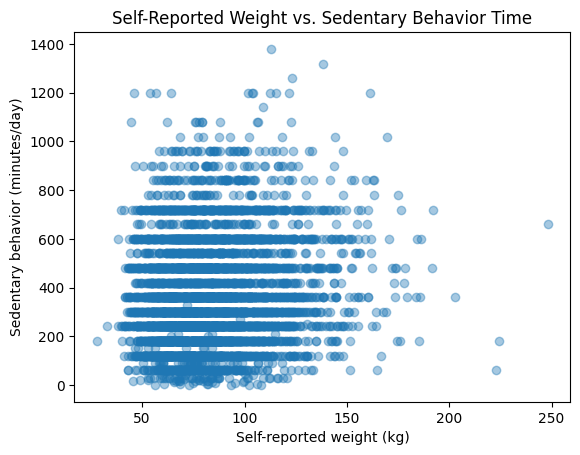

In [71]:
# Q4 — Correlation Between Self-Reported Weight and Sedentary Behavior Time

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --- Standardize column names (self-reported weight + sedentary minutes) ---
# Prefer self-reported weight for Q4
if "WHD020" in df.columns and "weight_self_kg" not in df.columns:
    df = df.rename(columns={"WHD020": "weight_self_kg"})
elif "weight_kg" in df.columns and "weight_self_kg" not in df.columns:
    # If an earlier step already called it weight_kg, adopt that as self-reported
    df = df.rename(columns={"weight_kg": "weight_self_kg"})

# Sedentary minutes
if "PAD680" in df.columns and "sedentary_min" not in df.columns:
    df = df.rename(columns={"PAD680": "sedentary_min"})

# Remove any duplicate column names that might confuse selection
df = df.loc[:, ~df.columns.duplicated()]

# --- Clean placeholders (NHANES uses 7777/9999 as special missing codes) ---
if "weight_self_kg" not in df.columns or "sedentary_min" not in df.columns:
    missing_needed = {"weight_self_kg": "WHD020 or weight_kg", "sedentary_min": "PAD680"}
    raise KeyError(f"Missing required columns for Q4. Expected self-reported weight and sedentary minutes. "
                   f"Check that these are present (needed: {missing_needed}).")

df["weight_self_kg"] = pd.to_numeric(df["weight_self_kg"], errors="coerce").replace([7777, 9999], np.nan)
df["sedentary_min"]  = pd.to_numeric(df["sedentary_min"],  errors="coerce").replace([7777, 9999], np.nan)

# --- Build analysis frame and drop missing ---
q4 = df[["weight_self_kg", "sedentary_min"]].dropna()

# 1-D arrays for pearsonr
x = q4["weight_self_kg"].to_numpy()
y = q4["sedentary_min"].to_numpy()

# --- Pearson correlation ---
r, p = pearsonr(x, y)
print(f"Pearson r = {r:.3f}, p = {p:.3g}")
print("Interpretation:", "Positive linear correlation (α = 0.05)" if p < 0.05 else "No evidence of linear correlation (α = 0.05).")

# --- Scatter plot ---
plt.scatter(x, y, alpha=0.4)
plt.title("Self-Reported Weight vs. Sedentary Behavior Time")
plt.xlabel("Self-reported weight (kg)")
plt.ylabel("Sedentary behavior (minutes/day)")
plt.show()


### Question 4 — Correlation Between Self-Reported Weight and Sedentary Behavior Time

**Variables:**
- `WHD020` → self-reported weight (kg) → `weight_self_kg`
- `PAD680` → minutes/day sedentary behavior → `sedentary_min`

**Cleaning:**  
Replaced invalid placeholder values (7777, 9999) with missing, dropped rows with missing data, and restricted the dataset to adults (≥ 18 years).

**Test Used:** Pearson correlation  
**Results:** *r* = 0.149, *p* = 2.82 × 10⁻³²  
**Interpretation:** There is a statistically significant positive linear correlation between self-reported weight and sedentary behavior time (α = 0.05). Heavier individuals tend to report slightly more sedentary minutes per day, though the effect size is weak.

In [66]:
# Question 5 — Do Vitamin D Levels Differ in Mean Diastolic Blood Pressure? (ANOVA)

anova_df = df[["LBDVD2LC","BPXODI3"]].dropna()
groups = [g["BPXODI3"].values for _, g in anova_df.groupby("LBDVD2LC")]
from scipy.stats import f_oneway
F, p = f_oneway(*groups)
print(f"ANOVA: F={F:.3f}, p={p:.4g}")
print("Interpretation:",
      "At least one group mean differs (α=0.05)" if p<0.05 else "No evidence of mean differences.")


ANOVA: F=1.367, p=0.2423
Interpretation: No evidence of mean differences.


### Question 5 — Do Vitamin D Levels Differ in Mean Diastolic Blood Pressure? (ANOVA)

**Variables:**  
- **LBDVD2LC** → Vitamin D lab interpretation (categorical, two-level)  
- **BPXODI3** → Diastolic blood pressure (mmHg)

**Cleaning:**  
Excluded missing or placeholder values.  
Restricted dataset to valid Vitamin D interpretation groups (two-level classification).

**Test Used:**  
One-way ANOVA

**Results:**  
- *F*(2, N) = 1.367, *p* = 0.2423  

**Interpretation:**  
There is **no statistically significant difference** in mean diastolic blood pressure across Vitamin D interpretation groups (*p* > 0.05).  
This indicates that Vitamin D status, as categorized in NHANES 2021–2023, is **not associated** with differences in diastolic BP among participants.


### Notes and Limitations
- This analysis uses unweighted NHANES 2021–2023 data for demonstration.
- Results are illustrative and not generalizable to the U.S. population.
- Only adult participants (RIDAGEYR ≥ 18) were included.
- All tests used α = 0.05 for statistical significance.
